In [1]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
from harmony import harmonize
from anndata import AnnData
import anndata
from sklearn.utils import shuffle
import copy
import matplotlib.pyplot as plt
import xgboost as xgb
import anndata as ad
import importlib
import PlotConfusion as pc
importlib.reload(pc)
import PlotConfusion as pc
import matplotlib
import scipy.stats as stats
import matplotlib as mpl
import random
import math

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.3 scipy==1.10.1 pandas==2.0.2 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.10


In [3]:
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
matplotlib.rcParams.update(new_rc_params)
plt.rcParams.update({'axes.labelsize' : 16}) 

In [4]:
def plot_multidotplot(adatas, cmaps, groupby, group_order, gene_order, stack='v', vmin=0, vmax=2, dot_min=0, dot_max=1, adata_names=None, save='multidotplot.png', size_exp=1.5):
    adatas = list(reversed(adatas))
    cmaps = list(reversed(cmaps))
    num_adatas = len(adatas)

    if isinstance(adata_names, type(None)):
        adata_names = [str(i+1) for i in range(num_adatas)]
    else:
        if len(adata_names) != num_adatas:
            raise Exception('adata_names does not match the length of adatas')
        adata_names = list(reversed([str(i) for i in adata_names]))

    mean_dfs = []
    dot_size_dfs = []
    for i in range(num_adatas):
        adata = adatas[i]
        genedf = sc.get.obs_df(
            adata,
            keys=[groupby, *gene_order],
            use_raw=True
        )
        grouped = genedf.groupby(groupby, observed=True)
        mean_df = grouped.mean()
        
        genedf_bool = genedf.copy()
        print(genedf_bool)
        print(len(gene_order))
        genedf_bool[gene_order] = genedf[gene_order] > 0
        dot_size_df = genedf.copy()
        dot_size_df = genedf_bool.groupby(groupby, observed=True).sum()/genedf_bool.groupby(groupby, observed=True).count()

        mean_dfs.append(mean_df)
        dot_size_dfs.append(dot_size_df)

    xs = []
    ys = []
    if stack == 'v':
        for i in range(num_adatas):
            xs_single = []
            ys_single = []
            for j in range(len(gene_order)):
                ys_single.append((num_adatas*(j+1)-(num_adatas-i-1))*np.ones(len(group_order)))
                xs_single.append(np.ones(len(group_order))+np.arange(len(group_order)))
            xs.append(xs_single)
            ys.append(ys_single)
    elif stack == 'h':
        for i in range(num_adatas):
            xs_single = []
            ys_single = []
            for j in range(len(gene_order)):
                ys_single.append((j+1)*np.ones(len(group_order)))
                xs_single.append((i+1)*np.ones(len(group_order))+num_adatas*np.arange(len(group_order)))
            xs.append(xs_single)
            ys.append(ys_single)
    else:
        raise Exception('stack must be \'v\' or \'h\'')

    if stack == 'v':
        fig_width = len(group_order)/3
        fig_height = num_adatas*len(gene_order)/3
    elif stack == 'h':
        fig_width = num_adatas*len(group_order)/3
        fig_height = len(gene_order)/3

    fig, ax = plt.subplots(figsize=(fig_width,fig_height))

    for i in range(num_adatas):
        colors = np.flip(mean_dfs[i].T[group_order].to_numpy(), axis=0).flatten()
        sizes = 200*np.flip(dot_size_dfs[i].T[group_order].to_numpy(), axis=0).flatten()**size_exp
        plt.scatter(xs[i], ys[i], c=colors, cmap=cmaps[i], s=sizes, vmin=vmin, vmax=vmax, edgecolor='black', linewidth=0.2)
    if stack == 'v':
        plt.xticks(np.arange(len(group_order))+1, group_order, rotation=90)
        label_locs = list(np.arange(0, num_adatas*len(gene_order), num_adatas)+(num_adatas+1)/2)
        labels = list(reversed(gene_order))
        for i in np.arange(num_adatas*len(gene_order))+1:
            if i not in label_locs:
                label_locs.append(i)
                labels.append('')
        plt.yticks(label_locs, labels)
        plt.xlim([0,len(group_order)+1])
        plt.ylim([0,num_adatas*len(gene_order)+1])
        for i in np.arange(len(gene_order)):
            y0 = num_adatas*i+1
            y1 = num_adatas*(i+1)
            line = plt.plot([-0.2, -0.2], [y0, y1], linewidth = 1, color='black')
            line[0].set_clip_on(False)
    elif stack == 'h':
        label_locs = list(np.arange(0, num_adatas*len(group_order), num_adatas)+(num_adatas+1)/2)
        labels = group_order.copy()
        for i in np.arange(num_adatas*len(group_order))+1:
            if i not in label_locs:
                label_locs.append(i)
                labels.append('')
        plt.xticks(label_locs, labels, rotation=90)
        plt.yticks(np.arange(len(gene_order))+1, list(reversed(gene_order)))
        plt.xlim([0,num_adatas*len(group_order)+1])
        plt.ylim([0,len(gene_order)+1])
        for i in np.arange(len(group_order)):
            x0 = num_adatas*i+1
            x1 = num_adatas*(i+1)
            line = plt.plot([x0, x1], [-0.2, -0.2], linewidth = 1, color='black')
            line[0].set_clip_on(False)
    plt.grid(False)

    num_legend_dots = 5
    size_pos = np.arange(num_legend_dots)
    size_sizes = np.arange(0.2, 1.01, 0.2)
    pos = ax.get_position()
    size_ax = fig.add_axes([pos.x1+0.225/fig_width, pos.y0+0.3/fig_height, 1.65/fig_width, 0.3/fig_height])
    size_ax.grid(False)
    size_ax.spines["right"].set_visible(False)
    size_ax.spines["top"].set_visible(False)
    size_ax.spines["left"].set_visible(False)
    size_ax.spines["bottom"].set_visible(False)
    size_ax.tick_params(axis="y", left=False, labelleft=False, labelright=False)
    size_ax.scatter(size_pos, len(size_pos)*[0], s=200*size_sizes**size_exp, color='gray', edgecolor='black', linewidth=0.2)
    size_ax.set_xlim([-1, num_legend_dots])
    size_ax.set_xticks(size_pos, [round(100*i) for i in size_sizes])
    size_ax.set_title("Fraction of cells\nin group (%)")

    size_pos = size_ax.get_position()
    current_y_pos = size_pos.y1
    for i in range(num_adatas):
        color_ax = fig.add_axes([size_pos.x0, current_y_pos+0.9/fig_height, 1.65/fig_width, 0.15/fig_height])
        cbar = mpl.colorbar.ColorbarBase(color_ax, cmap=cmaps[i], norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), orientation='horizontal')
        color_ax.set_title("Mean expression\nin " + adata_names[i])
        current_y_pos = color_ax.get_position().y1

    plt.savefig(save, bbox_inches='tight')

In [5]:
adata_p56 = sc.read_h5ad('adatas/P56_adata.h5ad')

In [6]:
C_types = []
for i in adata_p56.obs['Bio_type_cluster']:
    C_types.append('C' + i)
adata_p56.obs['C_type'] = pd.Categorical(C_types)

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


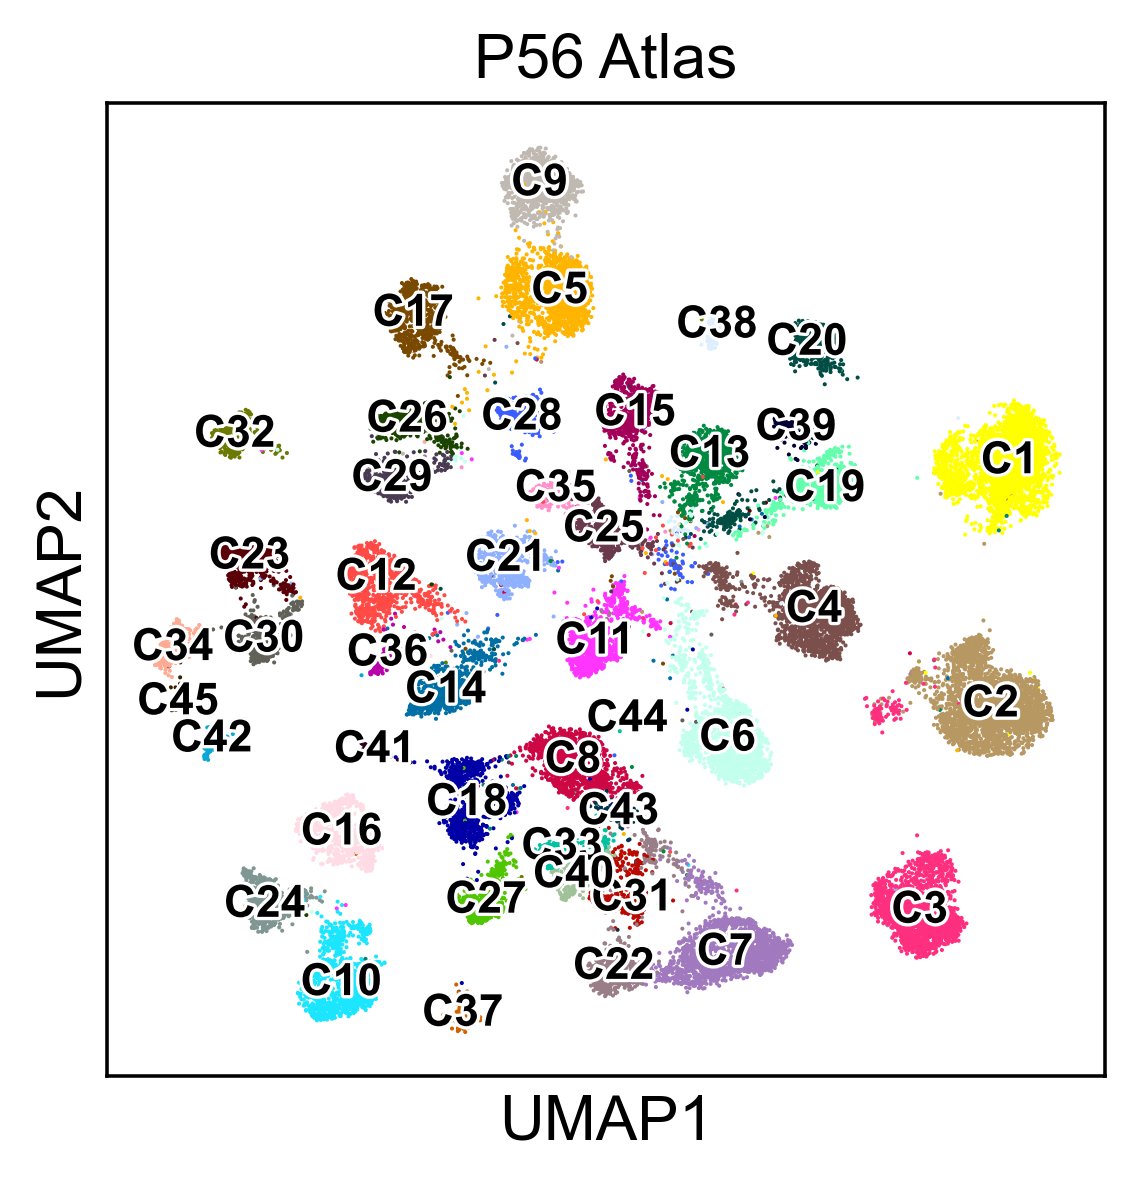

In [7]:
sc.set_figure_params(dpi=160,dpi_save=1000)
sc.pl.umap(adata_p56, color='C_type', legend_loc='on data', legend_fontoutline=1.5, legend_fontsize=10, title='P56 Atlas', save='P56_types.svg')

In [8]:
adata_p7 = sc.read_h5ad('adatas/P7_adata_pruned.h5ad')
adata_p7b2 = sc.read_h5ad('adatas/P7b2_adata_pruned.h5ad')

In [9]:
C_types = []
for i in adata_p7.obs['P56_type']:
    C_types.append('C' + str(i))
adata_p7.obs['C_type'] = pd.Categorical(C_types)

In [10]:
C_types = []
for i in adata_p7b2.obs['P56_type']:
    C_types.append('C' + str(i))
adata_p7b2.obs['C_type'] = pd.Categorical(C_types)

In [11]:
adata_combined = ad.concat([adata_p7, adata_p7b2], label='Condition', keys=['Control','β2-KO'])

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [12]:
sc.pp.scale(adata_combined, max_value=10)

In [13]:
sc.tl.pca(adata_combined, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:09)


In [14]:
Z = harmonize(adata_combined.obsm['X_pca'], adata_combined.obs, batch_key = 'Condition')
adata_combined.obsm['X_harmony'] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
Reach convergence after 6 iteration(s).


In [15]:
sc.pp.neighbors(adata_combined, n_neighbors=15, use_rep='X_harmony', knn=True)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:03:42)


In [16]:
sc.tl.umap(adata_combined)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:36)


C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


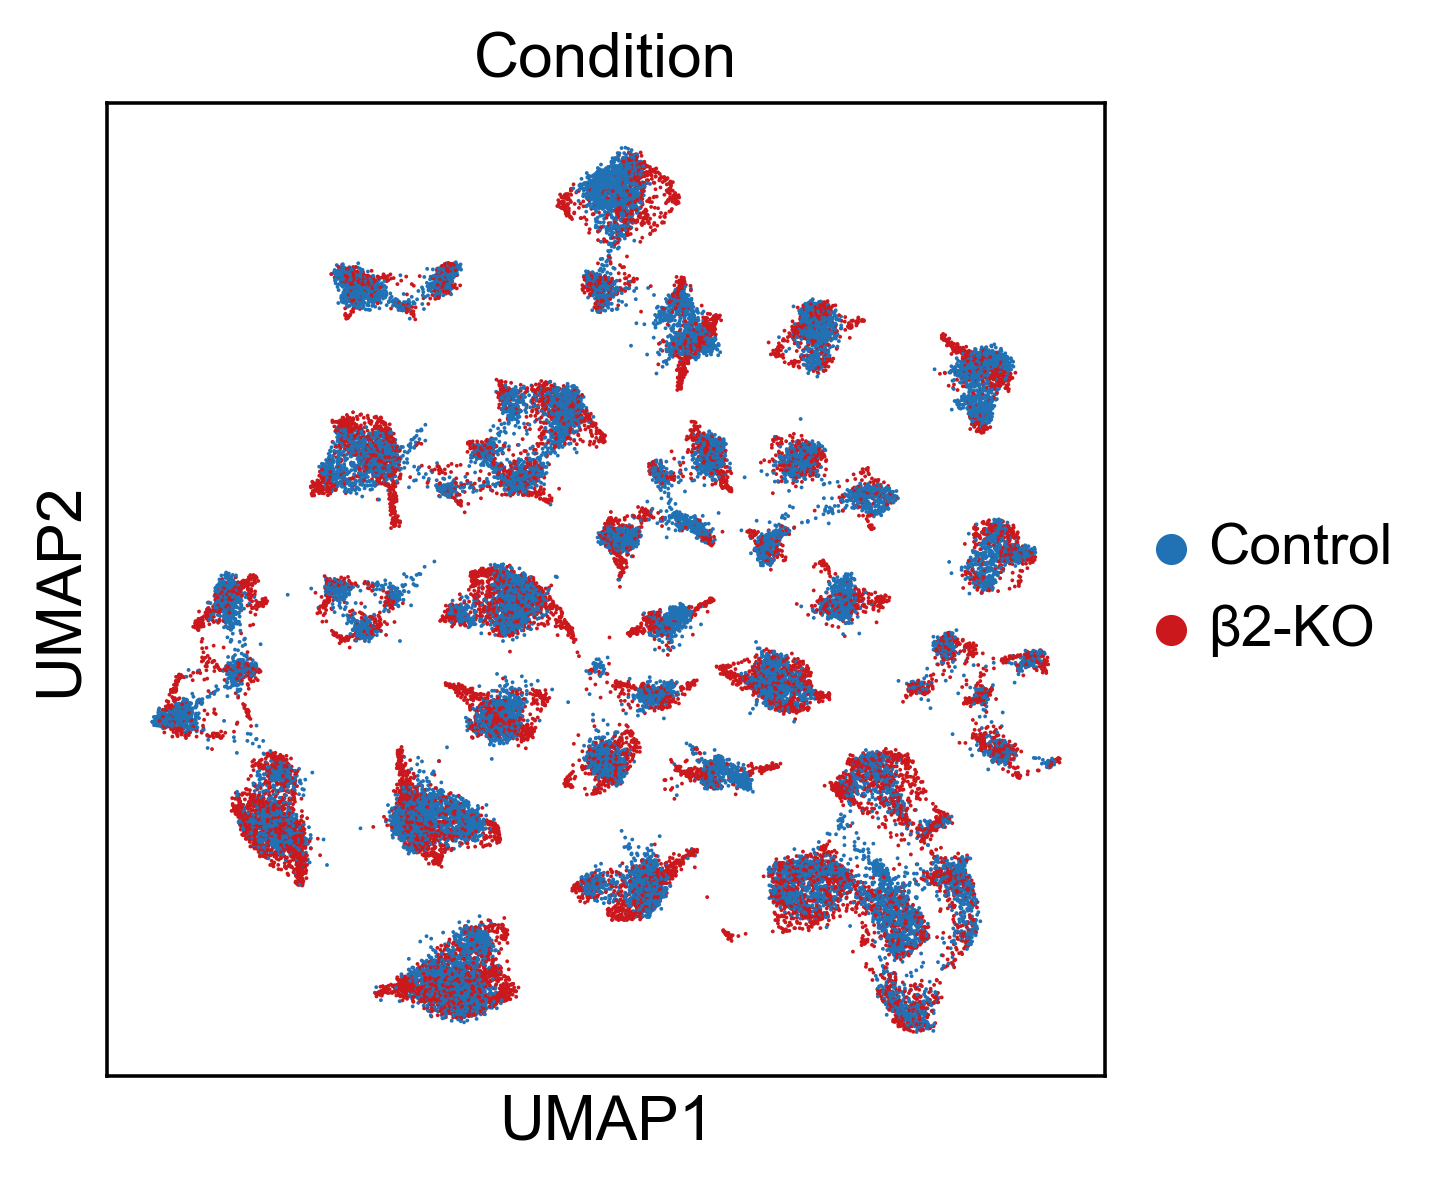

In [17]:
sc.pl.umap(shuffle(adata_combined), color=['Condition'], title='Condition', save='P7_conditions.svg', palette=['#2171b5','#cb181d'])

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


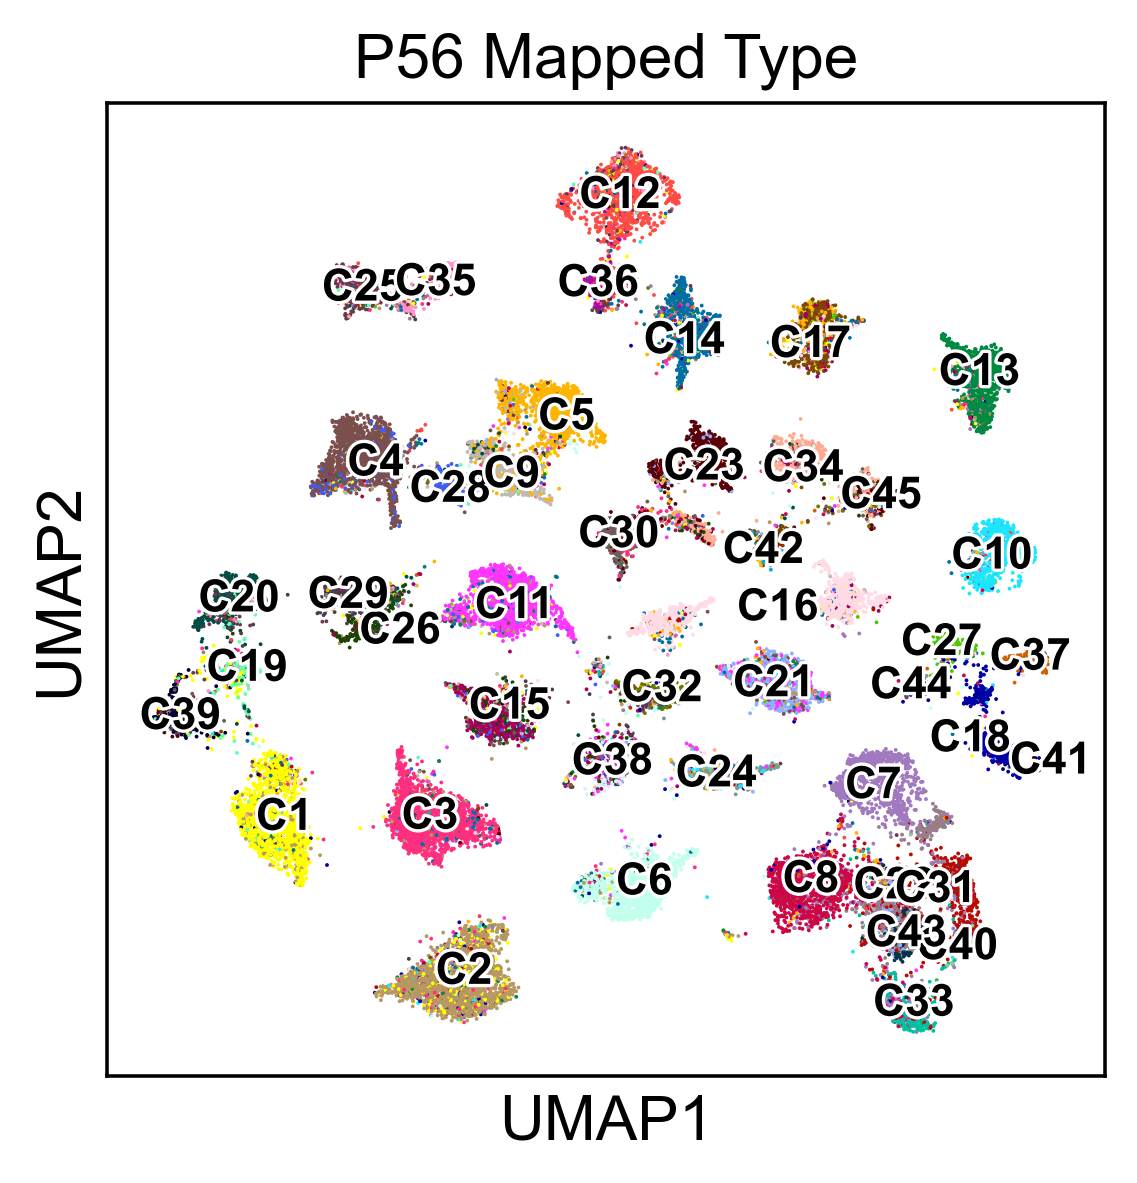

In [18]:
sc.set_figure_params(dpi=160,dpi_save=1000)
sc.pl.umap(adata_combined, color=['C_type'], title='P56 Mapped Type', legend_loc='on data', legend_fontoutline=1.5, legend_fontsize=10, save='P7_types.svg')

In [19]:
type_list = ['C' + str(i+1) for i in range(45)]

In [20]:
p7_pct = 15000/len(adata_p7)
p7b2_pct = 15000/len(adata_p7b2)
p7_downsampled_barcodes = []
p7b2_downsampled_barcodes = []
for i in type_list:
    p7_barcodes = list(adata_p7[adata_p7.obs['C_type'] == i].obs.index)
    p7b2_barcodes = list(adata_p7b2[adata_p7b2.obs['C_type'] == i].obs.index)
    [p7_downsampled_barcodes.append(x) for x in random.sample(p7_barcodes, math.ceil(p7_pct*len(p7_barcodes)))]
    [p7b2_downsampled_barcodes.append(x) for x in random.sample(p7b2_barcodes, math.ceil(p7b2_pct*len(p7b2_barcodes)))]

In [21]:
adata_p7_downsampled = adata_p7[adata_p7.obs.index.isin(p7_downsampled_barcodes)]
adata_p7b2_downsampled = adata_p7b2[adata_p7b2.obs.index.isin(p7b2_downsampled_barcodes)]

In [22]:
adata_combined_downsampled = ad.concat([adata_p7_downsampled, adata_p7b2_downsampled], label='Condition', keys=['Control P7', 'β2-KO P7'])

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [23]:
sc.pp.scale(adata_combined_downsampled, max_value=10)

In [24]:
sc.tl.pca(adata_combined_downsampled, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:03)


In [25]:
Z = harmonize(adata_combined_downsampled.obsm['X_pca'], adata_combined_downsampled.obs, batch_key = 'Condition')
adata_combined_downsampled.obsm['X_harmony'] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
Reach convergence after 6 iteration(s).


In [26]:
sc.pp.neighbors(adata_combined_downsampled, n_neighbors=15, use_rep='X_harmony', knn=True)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [27]:
sc.tl.umap(adata_combined_downsampled)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


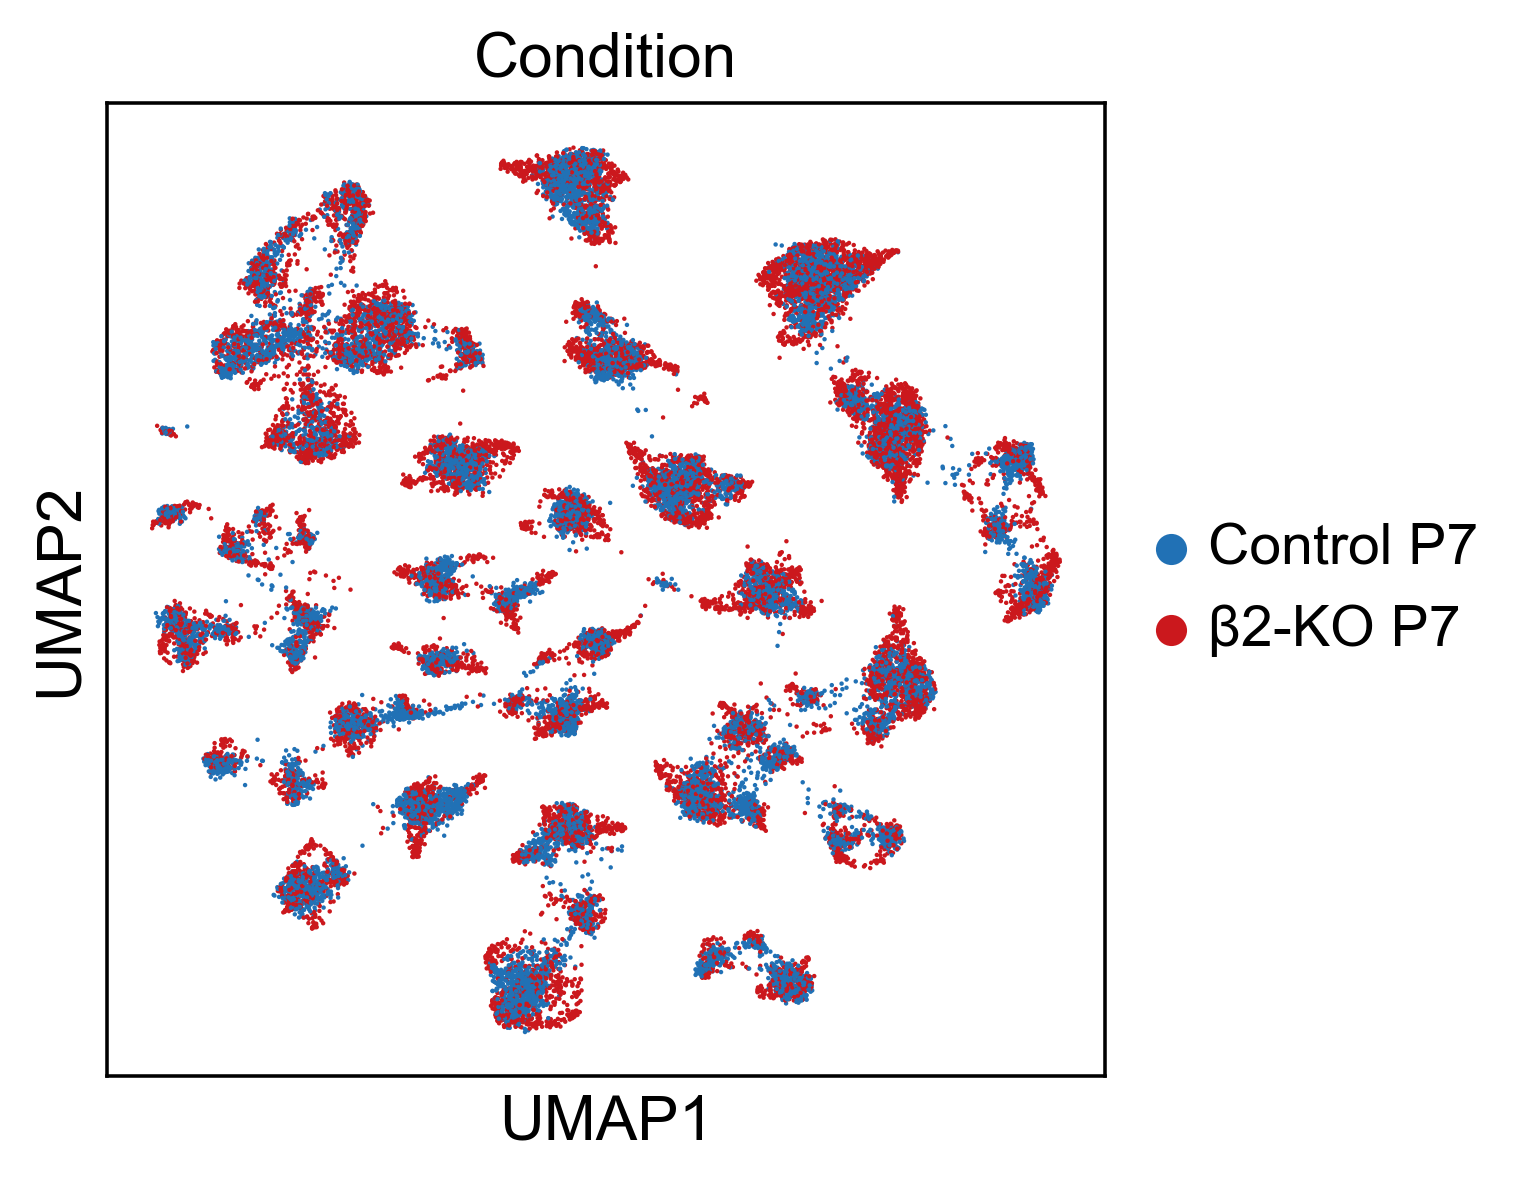

In [28]:
sc.set_figure_params(dpi=160,dpi_save=1000)
sc.pl.umap(shuffle(adata_combined_downsampled), color=['Condition'], title='Condition', save='P7_conditions_downsampled.svg', palette=['#2171b5','#cb181d'])

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


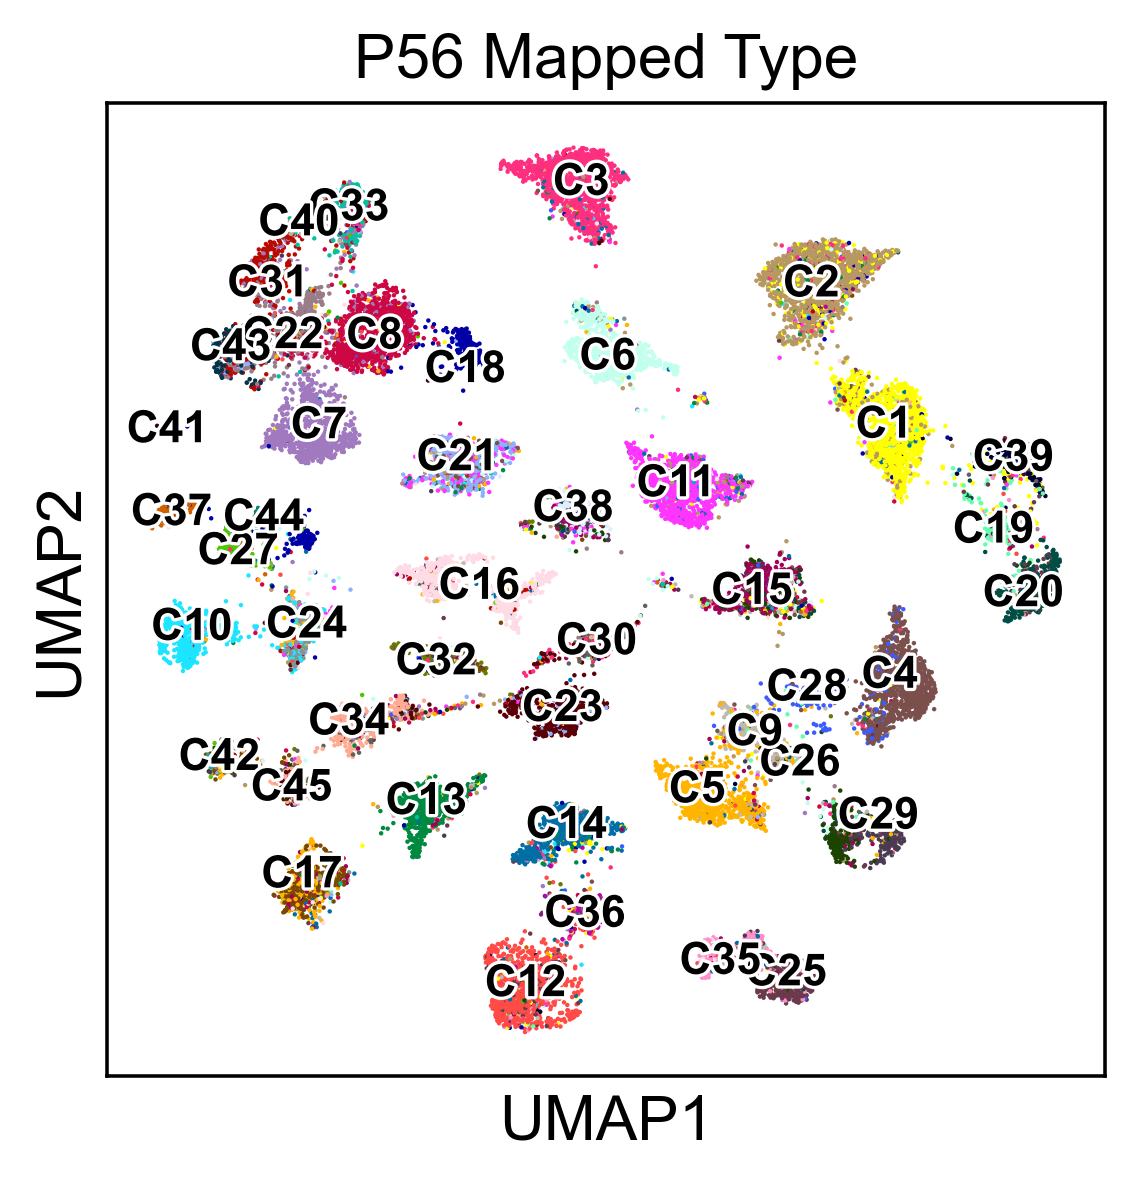

In [29]:
sc.set_figure_params(dpi=160,dpi_save=1000)
sc.pl.umap(adata_combined_downsampled, color=['C_type'], title='P56 Mapped Type', legend_loc='on data', legend_fontoutline=1.5, legend_fontsize=10, save='P7_types_downsampled.svg')

In [30]:
p7_condition_type = []
for i in adata_p7.obs['C_type']:
    p7_condition_type.append("Control_" + i)
adata_p7.obs['Condition_type'] = pd.Categorical(p7_condition_type)

In [31]:
p7b2_condition_type = []
for i in adata_p7b2.obs['C_type']:
    p7b2_condition_type.append("β2-KO_" + i)
adata_p7b2.obs['Condition_type'] = pd.Categorical(p7b2_condition_type)

In [32]:
p56_condition_type = []
for i in adata_p56.obs['C_type']:
    p56_condition_type.append("P56_" + i)
adata_p56.obs['Condition_type'] = pd.Categorical(p56_condition_type)

In [33]:
adata_all_combined = ad.concat([adata_p7[adata_p7.obs['C_type'] != 'C45'], adata_p7b2, adata_p56[adata_p56.obs['C_type'] != 'C45']], label='Condition', keys=['Control', 'β2-KO', 'P56'])

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [34]:
TFs = ['Eomes', 'Eomes', 'Eomes', 'Irx3', 'Irx3', 'Irx3', 'Tbr1', 'Tbr1', 'Tbr1', 'Mafb', 'Mafb', 'Mafb', 'Foxp2', 'Foxp2', 'Foxp2', 'Neurod2', 'Neurod2', 'Neurod2', 'Tfap2d', 'Tfap2d', 'Tfap2d', 'Bnc2', 'Bnc2', 'Bnc2']#, 'Zic1', 'Zic1', 'Zic1']

In [35]:
TFs = ['Eomes', 'Irx3', 'Tbr1', 'Mafb', 'Foxp2', 'Neurod2', 'Tfap2d', 'Bnc2']

In [36]:
type_order = [7, 8, 22, 31, 33, 40, 43, 18, 27, 37, 41, 44, 5, 9, 17, 21, 42, 23, 30, 34, 45, 3, 4, 28, 32, 38, 12, 19, 20, 25, 26, 29, 35, 39, 13, 14, 36, 16, 10, 24, 6, 1, 2, 11, 15]
reordered_types = ["C" + str(i) for i in type_order]
groupings = []
for i in reordered_types:
    groupings.append('Control_' + i)
    groupings.append('β2-KO_' + i)
    groupings.append('P56_' + i)

                          C_type     Eomes      Irx3      Tbr1      Mafb  \
aRGC1_AAACCTGAGAATCTCC-1      C7  0.960415  0.000000  0.000000  0.000000   
aRGC1_AAACCTGAGCGACGTA-1     C40  1.772917  0.000000  0.000000  0.000000   
aRGC1_AAACCTGGTAAATGAC-1     C40  2.010015  0.000000  0.000000  0.000000   
aRGC1_AAACCTGTCAAGGCTT-1     C27  0.000000  1.404052  0.000000  0.797931   
aRGC1_AAACGGGAGCAGCGTA-1     C19  0.000000  0.000000  0.000000  0.000000   
...                          ...       ...       ...       ...       ...   
aRGC10_TTTGTCAAGGAACTGC-1     C2  0.987456  0.987456  0.000000  0.000000   
aRGC10_TTTGTCAAGTAGGTGC-1     C2  0.000000  1.584308  0.000000  0.959371   
aRGC10_TTTGTCACATGTAAGA-1     C8  1.195393  0.877174  0.000000  0.000000   
aRGC10_TTTGTCAGTCTAGGTT-1     C3  0.000000  0.000000  1.532254  0.000000   
aRGC10_TTTGTCATCGCCTGAG-1     C4  0.000000  0.000000  0.000000  0.000000   

                              Foxp2   Neurod2  Tfap2d  Bnc2  
aRGC1_AAACCTGAGAATCTCC-1 

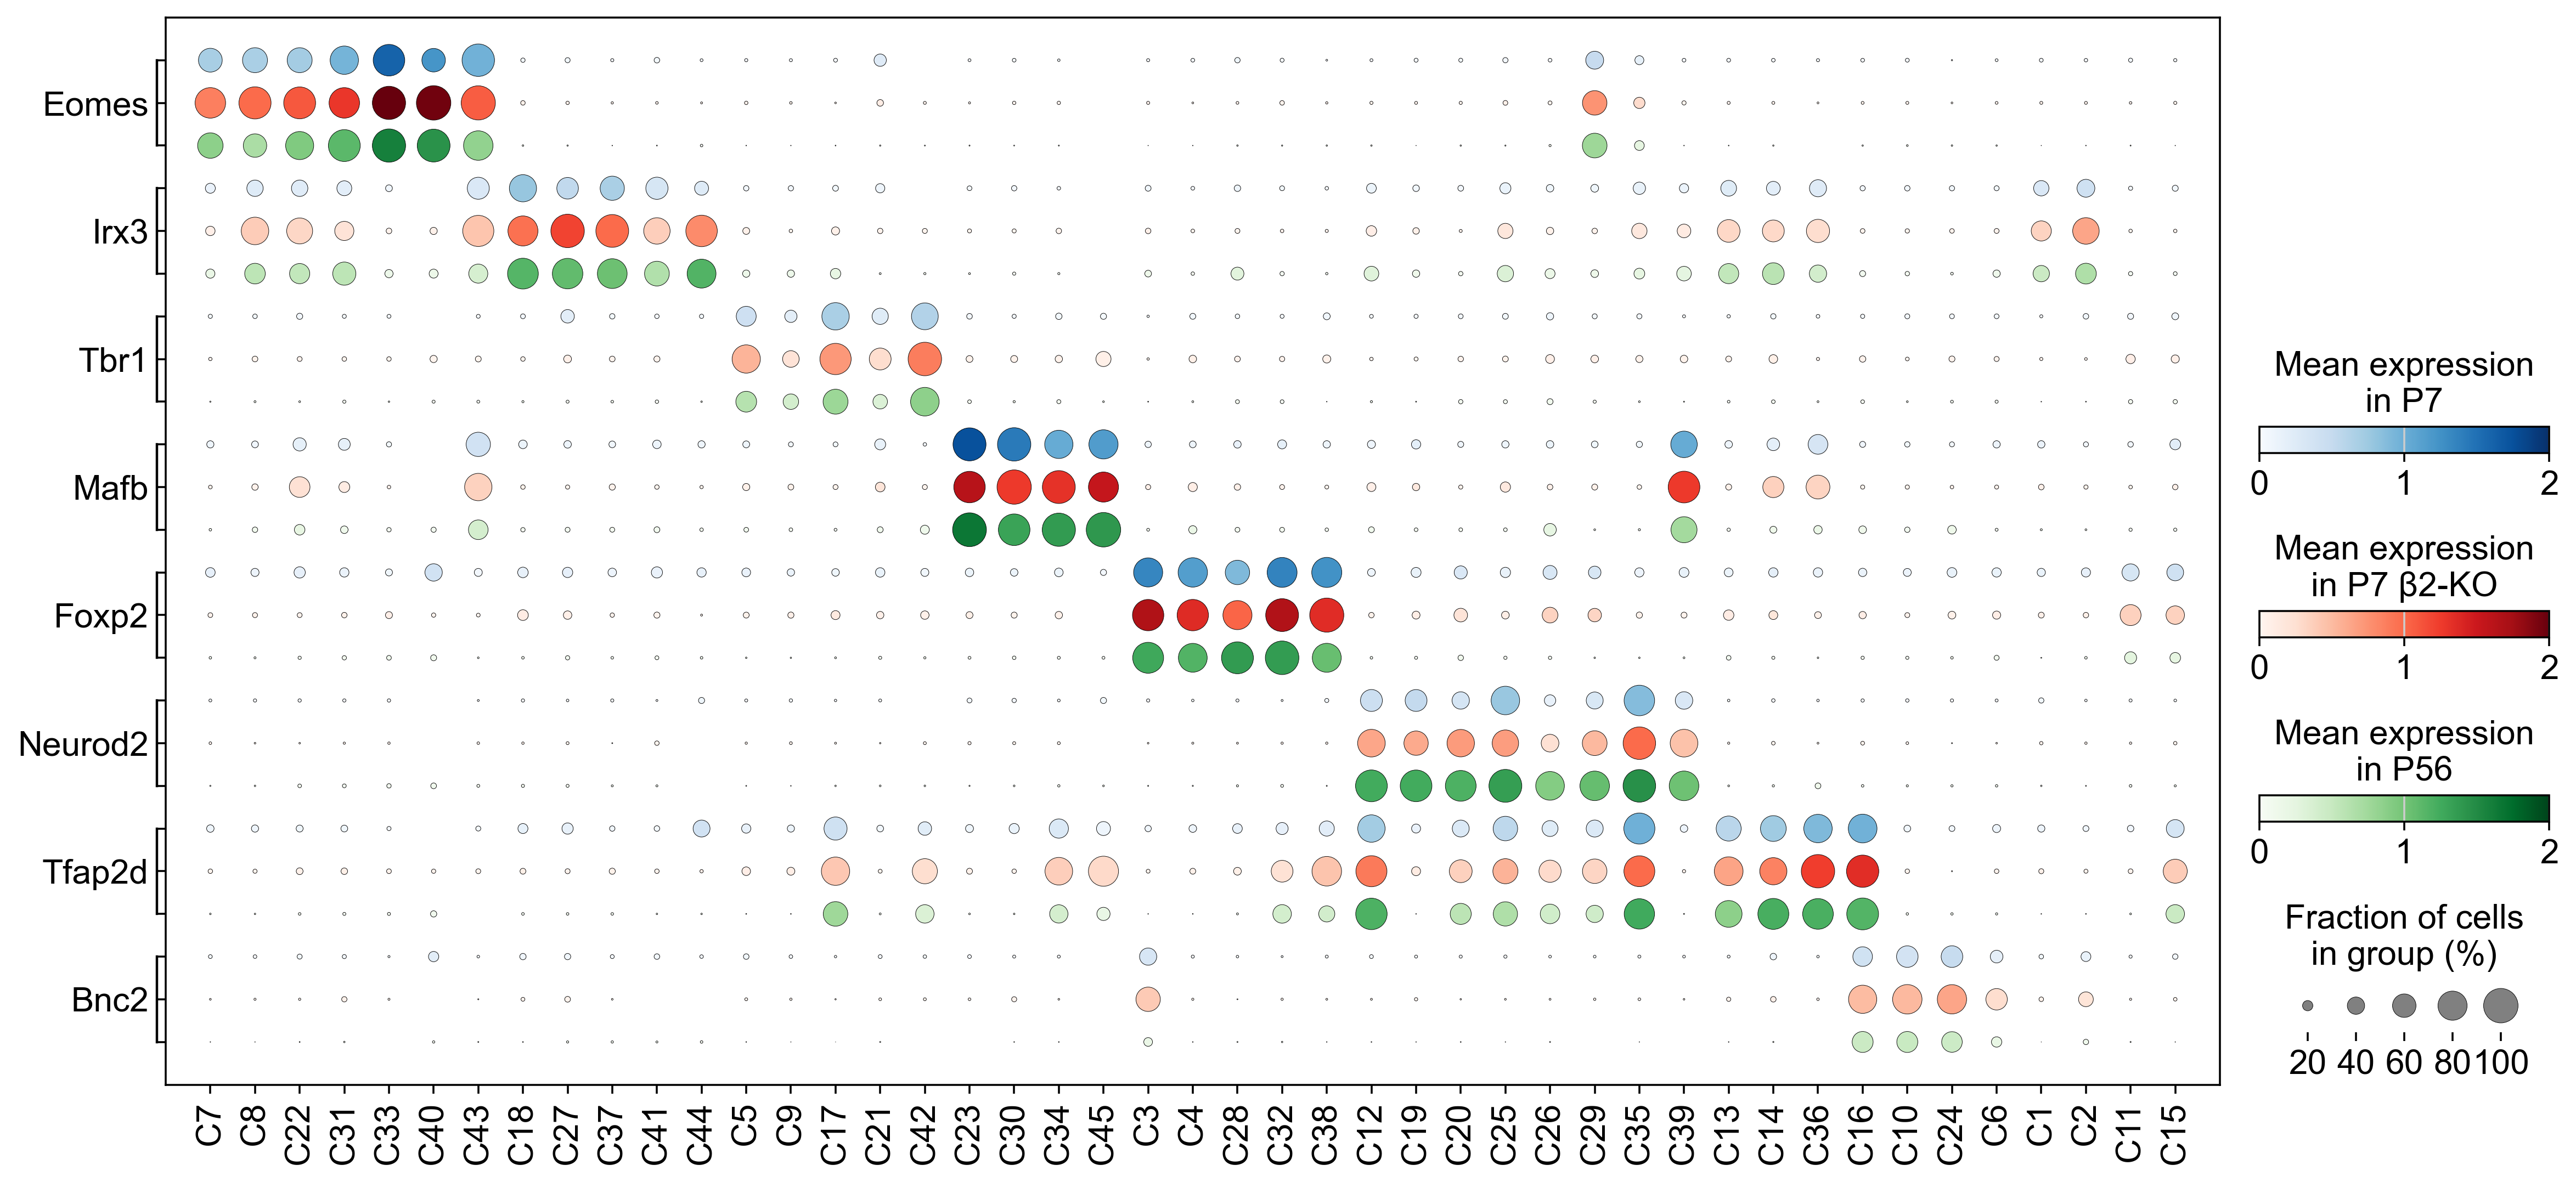

In [37]:
plot_multidotplot([adata_p7, adata_p7b2, adata_p56], ['Blues', 'Reds', 'Greens'], 'C_type', reordered_types, TFs, stack='v', vmin=0, vmax=2, dot_min=0, dot_max=1, adata_names=['P7', 'P7 β2-KO', 'P56'], save='fig2_C.svg')

In [39]:
P7_P56_counts = []
P7b2_P56_counts = []
P56_P56_counts = []
for i in adata_p7.obs['P56_type'].cat.categories:
    P7_P56_counts.append(len(adata_p7[adata_p7.obs['P56_type'] == i]))
    P7b2_P56_counts.append(len(adata_p7b2[adata_p7b2.obs['P56_type'] == i]))
    P56_P56_counts.append(len(adata_p56[adata_p56.obs['Bio_type_cluster'] == str(i)]))

In [40]:
P7_P56_freqs = [i/sum(P7_P56_counts) for i in P7_P56_counts]
P7b2_P56_freqs = [i/sum(P7b2_P56_counts) for i in P7b2_P56_counts]
P56_P56_freqs = [i/sum(P56_P56_counts) for i in P56_P56_counts]

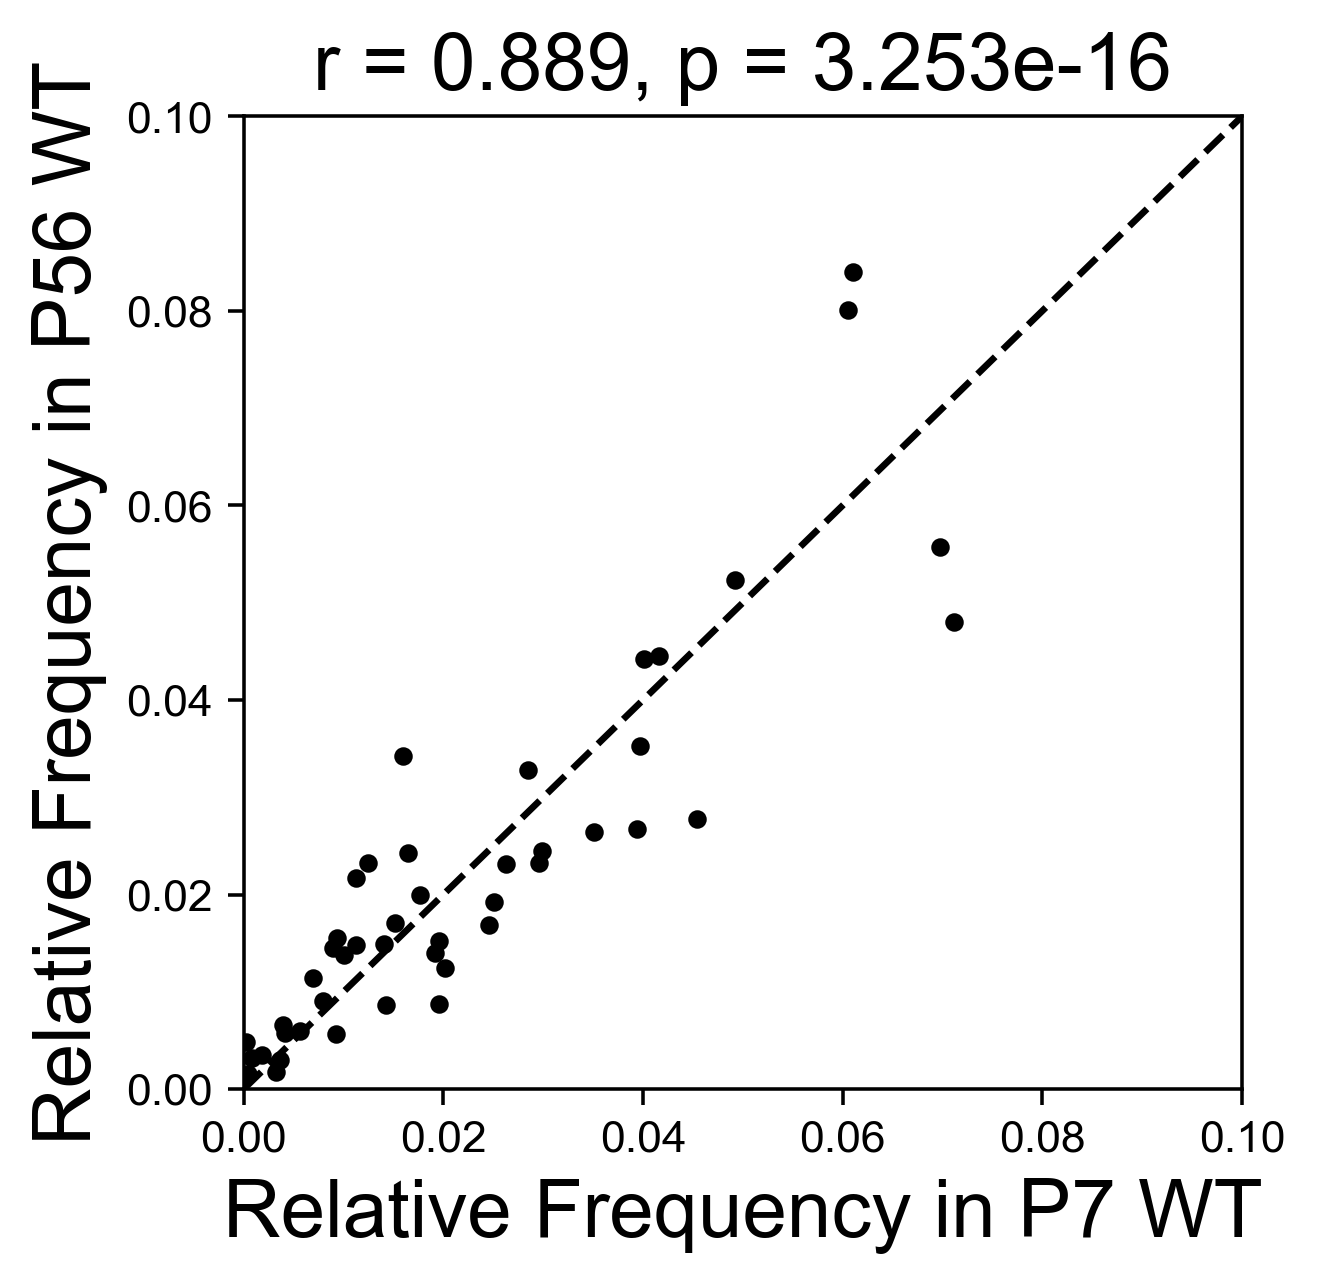

In [57]:
plt.scatter(P7_P56_freqs, P56_P56_freqs, color='black', s=10)
plt.plot([0,1], [0,1], ls='dashed', color='black')
plt.grid(False)
plt.xlim([0,0.1])
plt.ylim([0,0.1])
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Relative Frequency in P7 WT', fontsize=18)
plt.ylabel('Relative Frequency in P56 WT', fontsize=18)
r_val = stats.pearsonr(P7_P56_freqs, P56_P56_freqs)
plt.title('r = ' + str(round(r_val[0], 3)) + ', p = ' + '{:0.3e}'.format(r_val[1]), fontsize=18)
plt.savefig('P7_P56_Relative_Frequencies.svg', bbox_inches='tight')

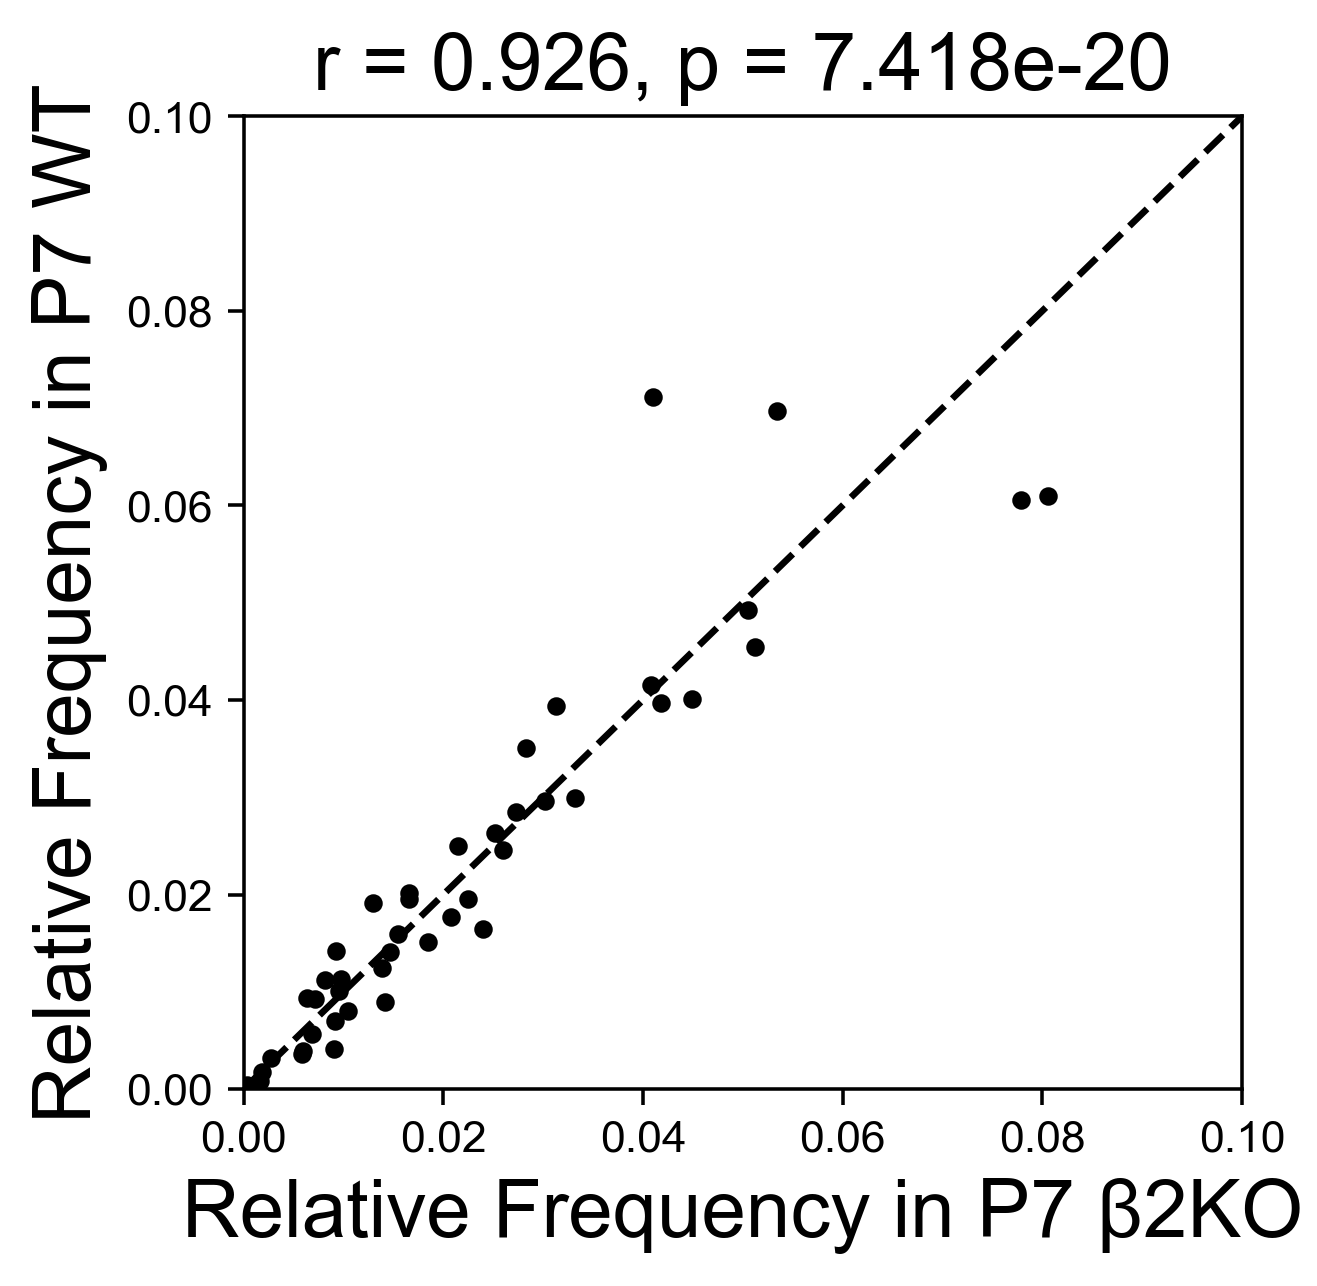

In [56]:
plt.scatter(P7b2_P56_freqs, P7_P56_freqs, color='black', s=10)
plt.plot([0,1], [0,1], ls='dashed', color='black')
plt.grid(False)
plt.xlim([0,0.1])
plt.ylim([0,0.1])
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Relative Frequency in P7 β2KO', fontsize=18)
plt.ylabel('Relative Frequency in P7 WT', fontsize=18)
r_val = stats.pearsonr(P7b2_P56_freqs, P7_P56_freqs)
plt.title('r = ' + str(round(r_val[0], 3)) + ', p = ' + '{:0.3e}'.format(r_val[1]), fontsize=18)
plt.savefig('P7b2_P7_Relative_Frequencies.svg', bbox_inches='tight')

In [45]:
adata_p7_rep1 = adata_p7[adata_p7.obs['Batch'] == 'Batch1']
adata_p7_rep2 = adata_p7[adata_p7.obs['Batch'] == 'Batch2']
adata_p7_rep3 = adata_p7[adata_p7.obs['Batch'] == 'Batch3']

In [46]:
adata_p7b2_rep1 = adata_p7b2[adata_p7b2.obs['Batch'].isin(['Batch1', 'Batch2'])]
adata_p7b2_rep2 = adata_p7b2[adata_p7b2.obs['Batch'] == 'Batch1_2']
adata_p7b2_rep3 = adata_p7b2[adata_p7b2.obs['Batch'] == 'Batch2_2']

In [47]:
P7rep1_P56_counts = []
P7rep2_P56_counts = []
P7b2rep1_P56_counts = []
P7b2rep2_P56_counts = []
for i in adata_p7.obs['P56_type'].cat.categories:
    P7rep1_P56_counts.append(len(adata_p7_rep1[adata_p7_rep1.obs['P56_type'] == i]))
    P7rep2_P56_counts.append(len(adata_p7_rep2[adata_p7_rep2.obs['P56_type'] == i]))
    P7b2rep1_P56_counts.append(len(adata_p7b2_rep1[adata_p7b2_rep1.obs['P56_type'] == i]))
    P7b2rep2_P56_counts.append(len(adata_p7b2_rep2[adata_p7b2_rep2.obs['P56_type'] == i]))

In [48]:
P7rep1_P56_freqs = [i/sum(P7rep1_P56_counts) for i in P7rep1_P56_counts]
P7rep2_P56_freqs = [i/sum(P7rep2_P56_counts) for i in P7rep2_P56_counts]
P7b2rep1_P56_freqs = [i/sum(P7b2rep1_P56_counts) for i in P7b2rep1_P56_counts]
P7b2rep2_P56_freqs = [i/sum(P7b2rep2_P56_counts) for i in P7b2rep2_P56_counts]

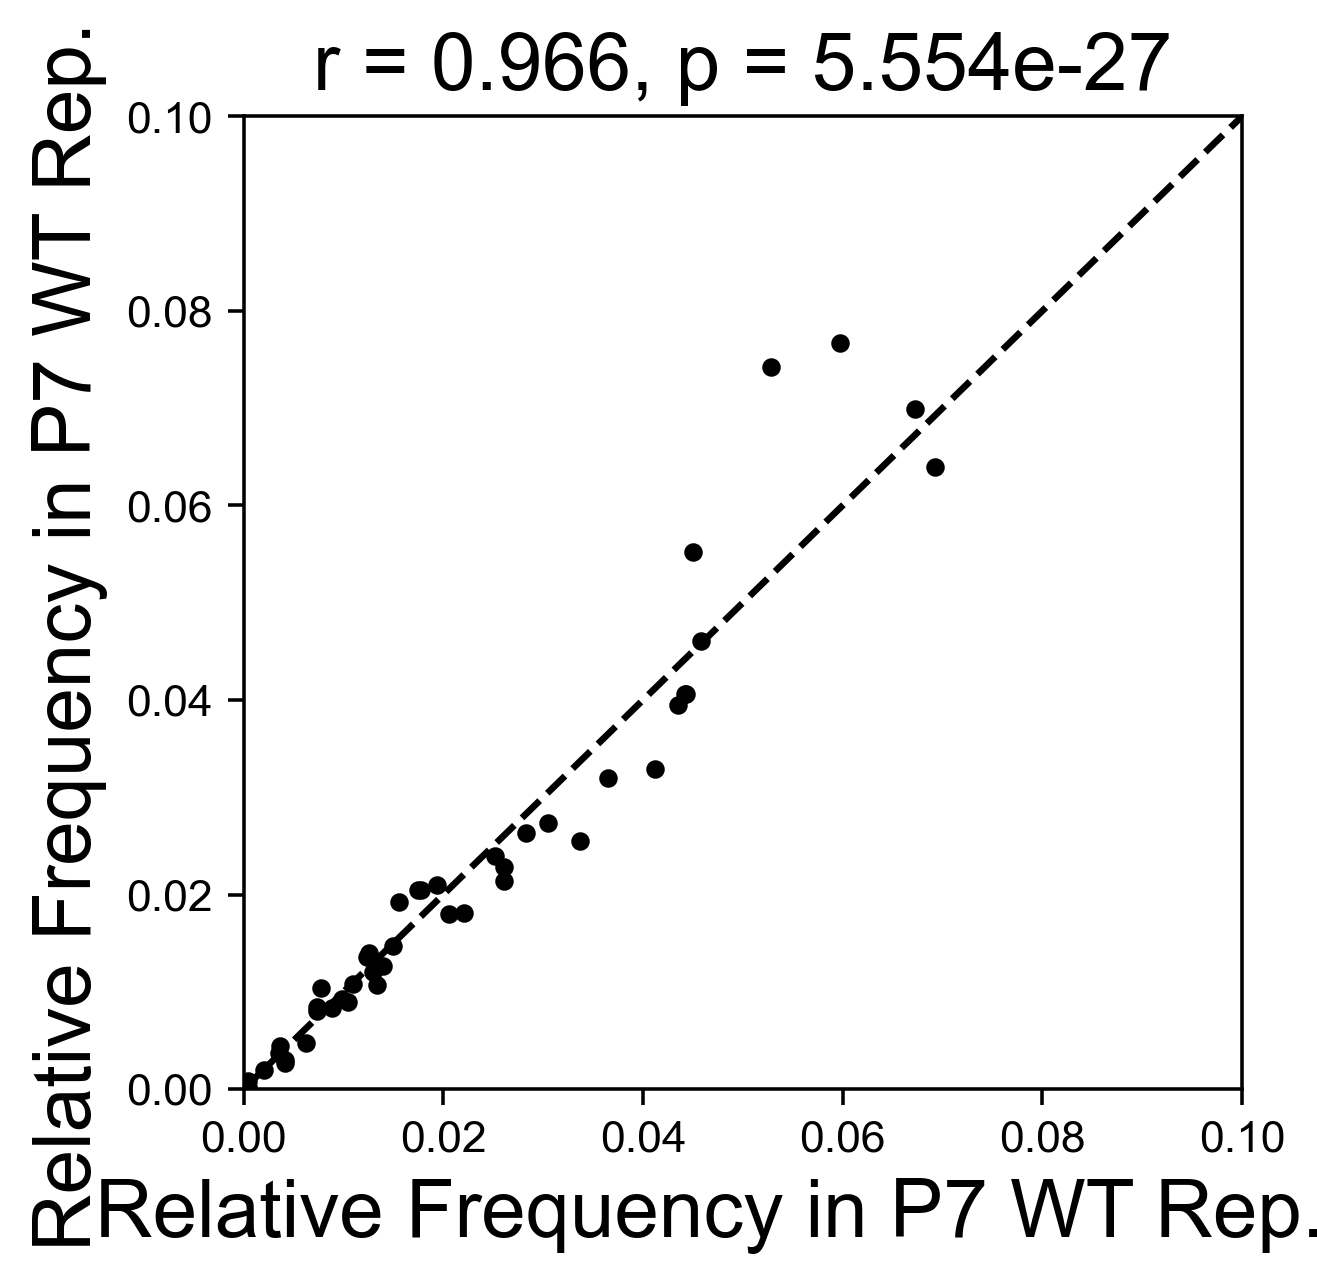

In [55]:
plt.scatter(P7rep1_P56_freqs, P7rep2_P56_freqs, color='black', s=10)
plt.plot([0,1], [0,1], ls='dashed', color='black')
plt.grid(False)
plt.xlim([0,0.1])
plt.ylim([0,0.1])
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Relative Frequency in P7 WT Rep. 1', fontsize=18)
plt.ylabel('Relative Frequency in P7 WT Rep. 2', fontsize=18)
r_val = stats.pearsonr(P7rep1_P56_freqs, P7rep2_P56_freqs)
plt.title('r = ' + str(round(r_val[0], 3)) + ', p = ' + '{:0.3e}'.format(r_val[1]), fontsize=18)
plt.savefig('P7rep1_P7rep2_Relative_Frequencies.svg', bbox_inches='tight')

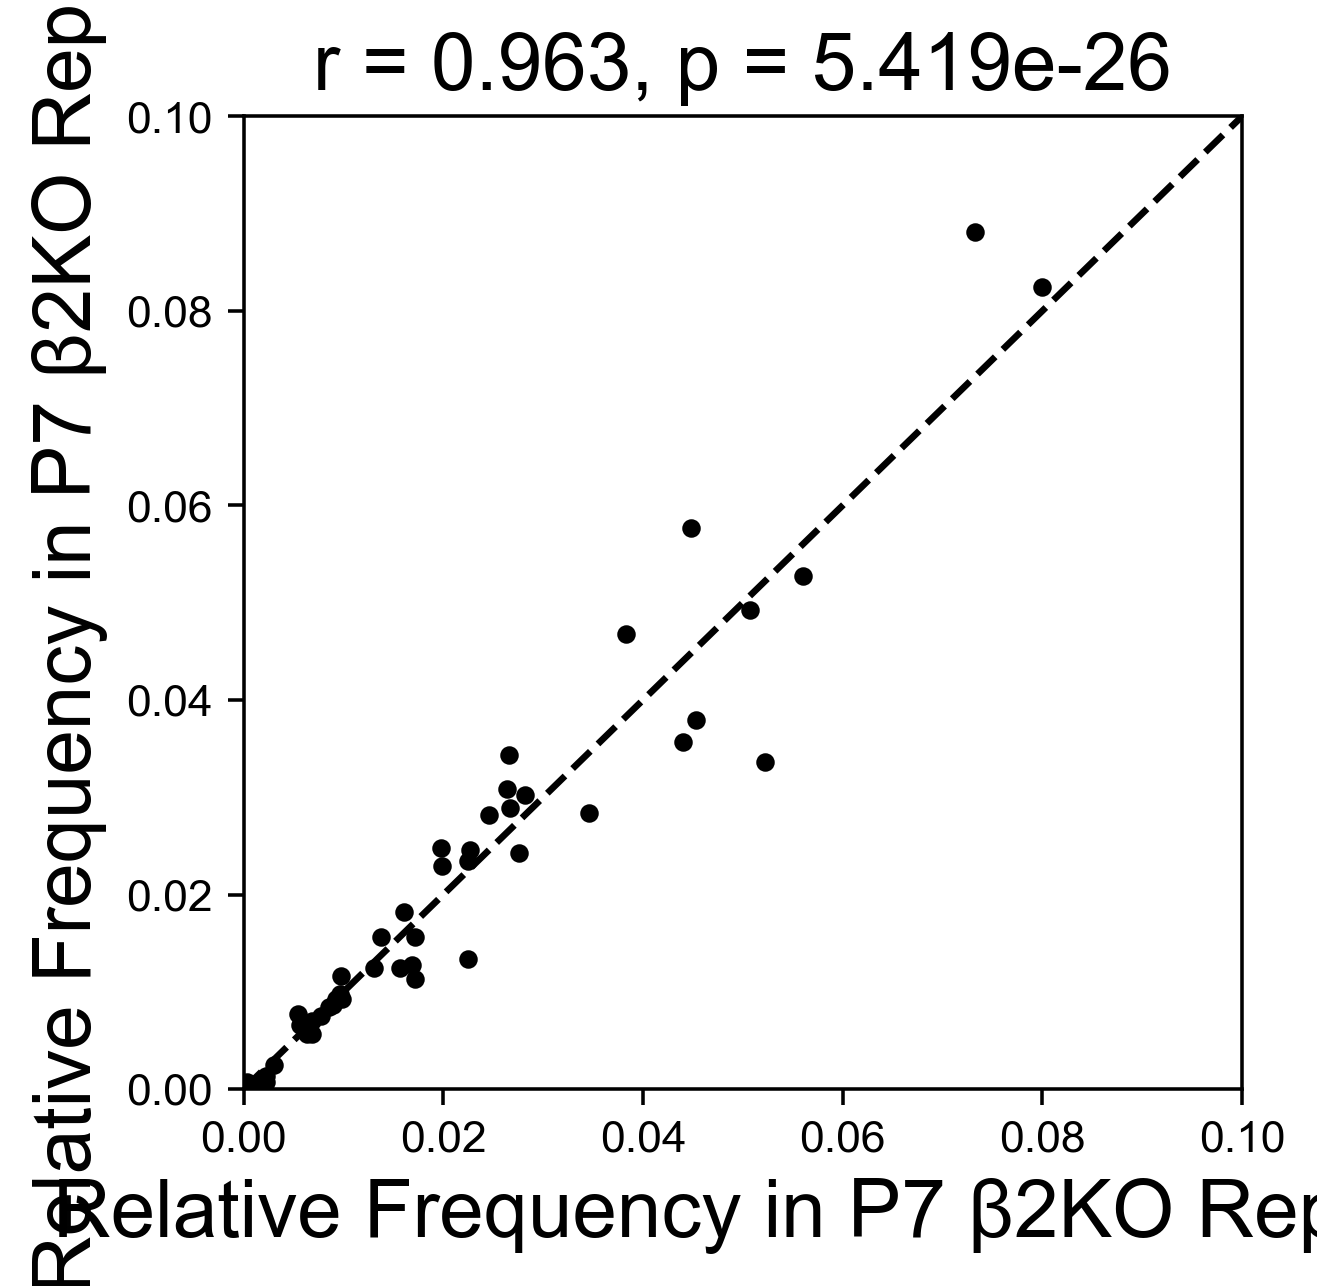

In [54]:
plt.scatter(P7b2rep1_P56_freqs, P7b2rep2_P56_freqs, color='black', s=10)
plt.plot([0,1], [0,1], ls='dashed', color='black')
plt.grid(False)
plt.xlim([0,0.1])
plt.ylim([0,0.1])
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Relative Frequency in P7 β2KO Rep. 1', fontsize=18)
plt.ylabel('Relative Frequency in P7 β2KO Rep. 2', fontsize=18)
r_val = stats.pearsonr(P7b2rep1_P56_freqs, P7b2rep2_P56_freqs)
plt.title('r = ' + str(round(r_val[0], 3)) + ', p = ' + '{:0.3e}'.format(r_val[1]), fontsize=18)
plt.savefig('P7b2rep1_P7b2rep2_Relative_Frequencies.svg', bbox_inches='tight')

In [55]:
TF_df = pd.read_csv('TF_list.txt', sep='\t', index_col=False)
TF_list = []
[TF_list.append(i) for i in list(TF_df['Symbol']) if i not in TF_list]
len(TF_list)

1350

In [56]:
CA_df = pd.read_csv('Cell_Adhesion_list.txt', sep='\t', index_col=False)
CA_list = []
[CA_list.append(i) for i in list(CA_df['Symbol']) if i not in CA_list]
len(CA_list)

1545

In [57]:
adata_p7.uns['log1p']['base'] = None
adata_p7b2.uns['log1p']['base'] = None
adata_p56.uns['log1p']['base'] = None

In [58]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.tl.rank_genes_groups(adata_p7, groupby='C_type', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:05)


In [59]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.tl.rank_genes_groups(adata_p7b2, groupby='C_type', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:47)


In [60]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.tl.rank_genes_groups(adata_p56, groupby='C_type', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:09)


In [61]:
de_dfs_p7 = {}
de_dfs_p7b2 = {}
de_dfs_p56 = {}
for i in ["C" + str(x+1) for x in range(45)]:
    df_p7 = sc.get.rank_genes_groups_df(adata_p7, i, pval_cutoff=0.05).sort_values('logfoldchanges', ascending=False)
    df_p7b2 = sc.get.rank_genes_groups_df(adata_p7b2, i, pval_cutoff=0.05).sort_values('logfoldchanges', ascending=False)
    df_p56 = sc.get.rank_genes_groups_df(adata_p56, i, pval_cutoff=0.05).sort_values('logfoldchanges', ascending=False)
    de_dfs_p7[i] = df_p7
    de_dfs_p7b2[i] = df_p7b2
    de_dfs_p56[i] = df_p56

In [64]:
de_TF_list = []
de_CA_list = []
for i in ["C" + str(x+1) for x in range(45)]:
    p7_tf_list = list(de_dfs_p7[i][de_dfs_p7[i]['names'].isin(TF_list)]['names'].values)
    p7b2_tf_list = list(de_dfs_p7b2[i][de_dfs_p7b2[i]['names'].isin(TF_list)]['names'].values)
    p56_tf_list = list(de_dfs_p56[i][de_dfs_p56[i]['names'].isin(TF_list)]['names'].values)
    for j in p7_tf_list:
        if j not in de_TF_list:
            if (j in p7b2_tf_list) and (j in p56_tf_list):
                de_TF_list.append(j)
    p7_ca_list = list(de_dfs_p7[i][de_dfs_p7[i]['names'].isin(CA_list)]['names'].values)
    p7b2_ca_list = list(de_dfs_p7b2[i][de_dfs_p7b2[i]['names'].isin(CA_list)]['names'].values)
    p56_ca_list = list(de_dfs_p56[i][de_dfs_p56[i]['names'].isin(CA_list)]['names'].values)
    for j in p7_ca_list:
        if j not in de_CA_list:
            if (j in p7b2_ca_list) and (j in p56_ca_list):
                de_CA_list.append(j)

In [ ]:
sc.pl.dotplot(adata_p7, de_TF_list, 'C_type', categories_order = reordered_types, swap_axes=True, cmap='Blues', vmax=2)

In [ ]:
sc.pl.dotplot(adata_p7, de_CA_list, 'C_type', categories_order = reordered_types, swap_axes=True, cmap='Blues', vmax=2)

In [99]:
supplemental_TFs = ['Tbx20', 'Zeb2', 'Irx1', 'Irx4', 'Esrrg', 'Sox6', 'Nr2f2', 'Etv1', 'Bhlhe22', 'Meis2', 'Isl2', 'Foxp1', 'Nfia', 'Runx1', 'Zic1']

In [100]:
supplemental_CAs = ['Kitl', 'Ndnf', 'Cdh7', 'Gldn', 'Dab1', 'Cdh8', 'Cdh1', 'Slc7a11', 'Ptprt']

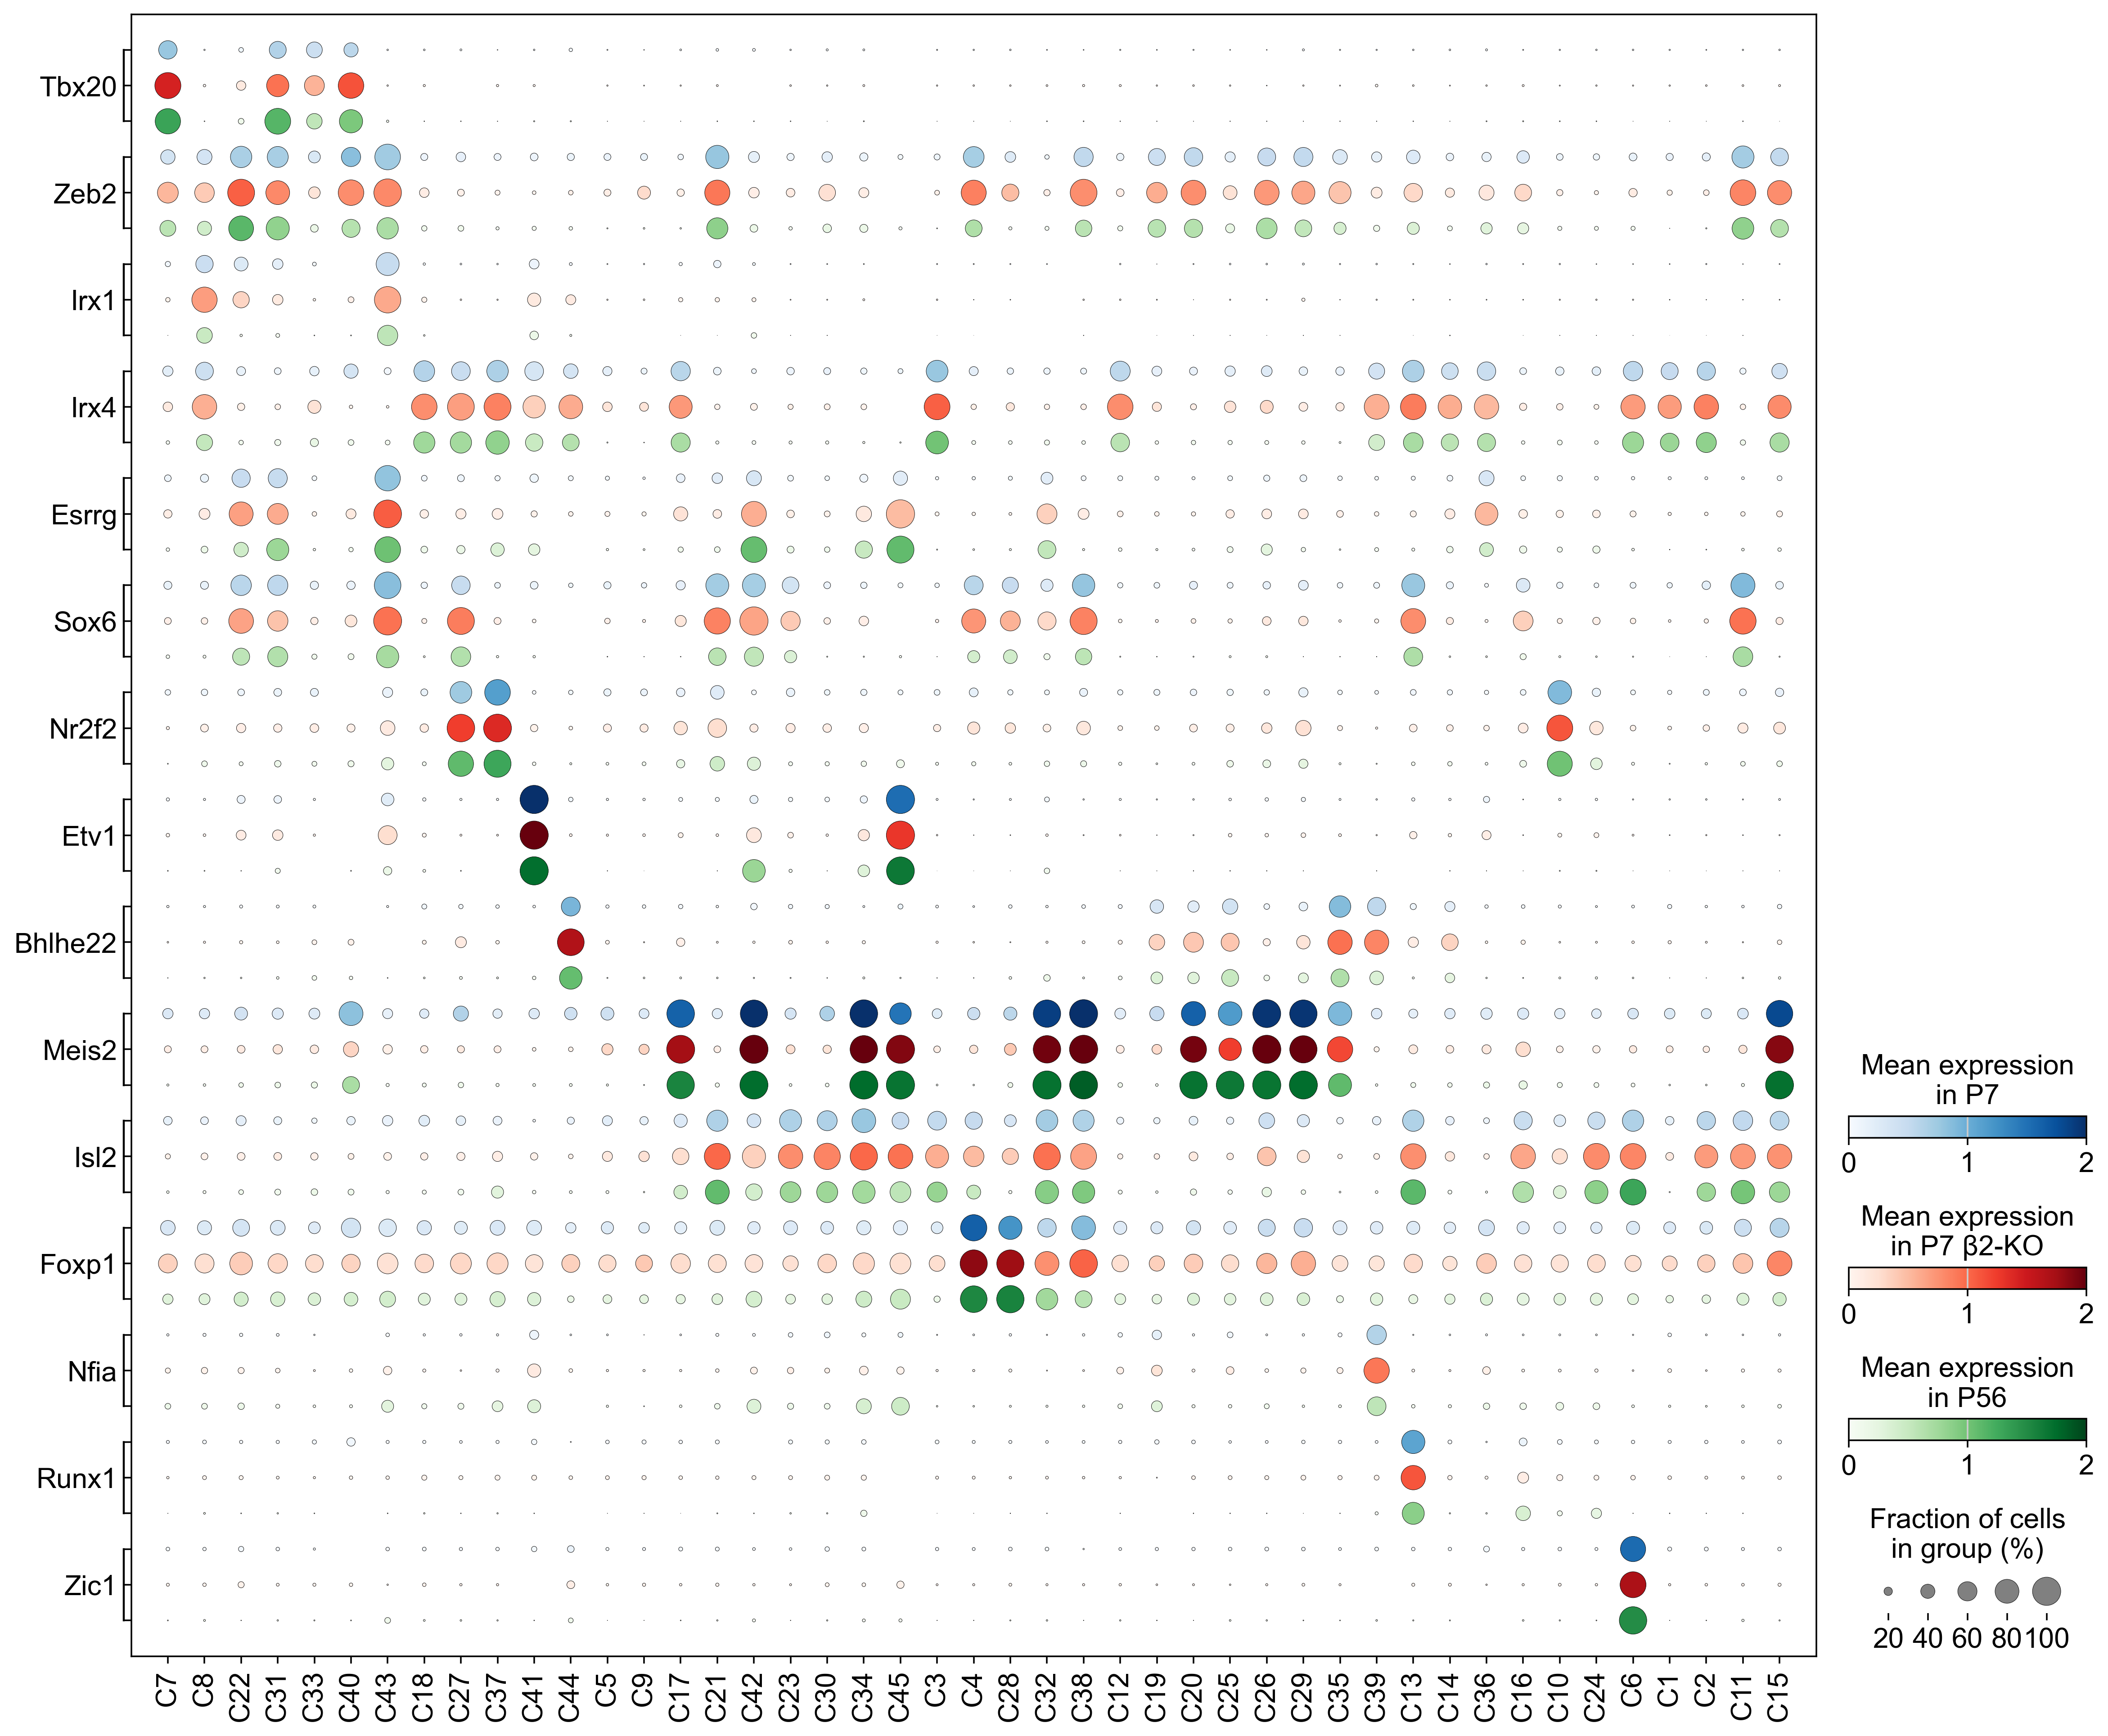

In [101]:
plot_multidotplot([adata_p7, adata_p7b2, adata_p56], ['Blues', 'Reds', 'Greens'], 'C_type', type_list, supplemental_TFs, adata_names=['P7','P7 β2-KO','P56'], save='supp_TFs.svg')

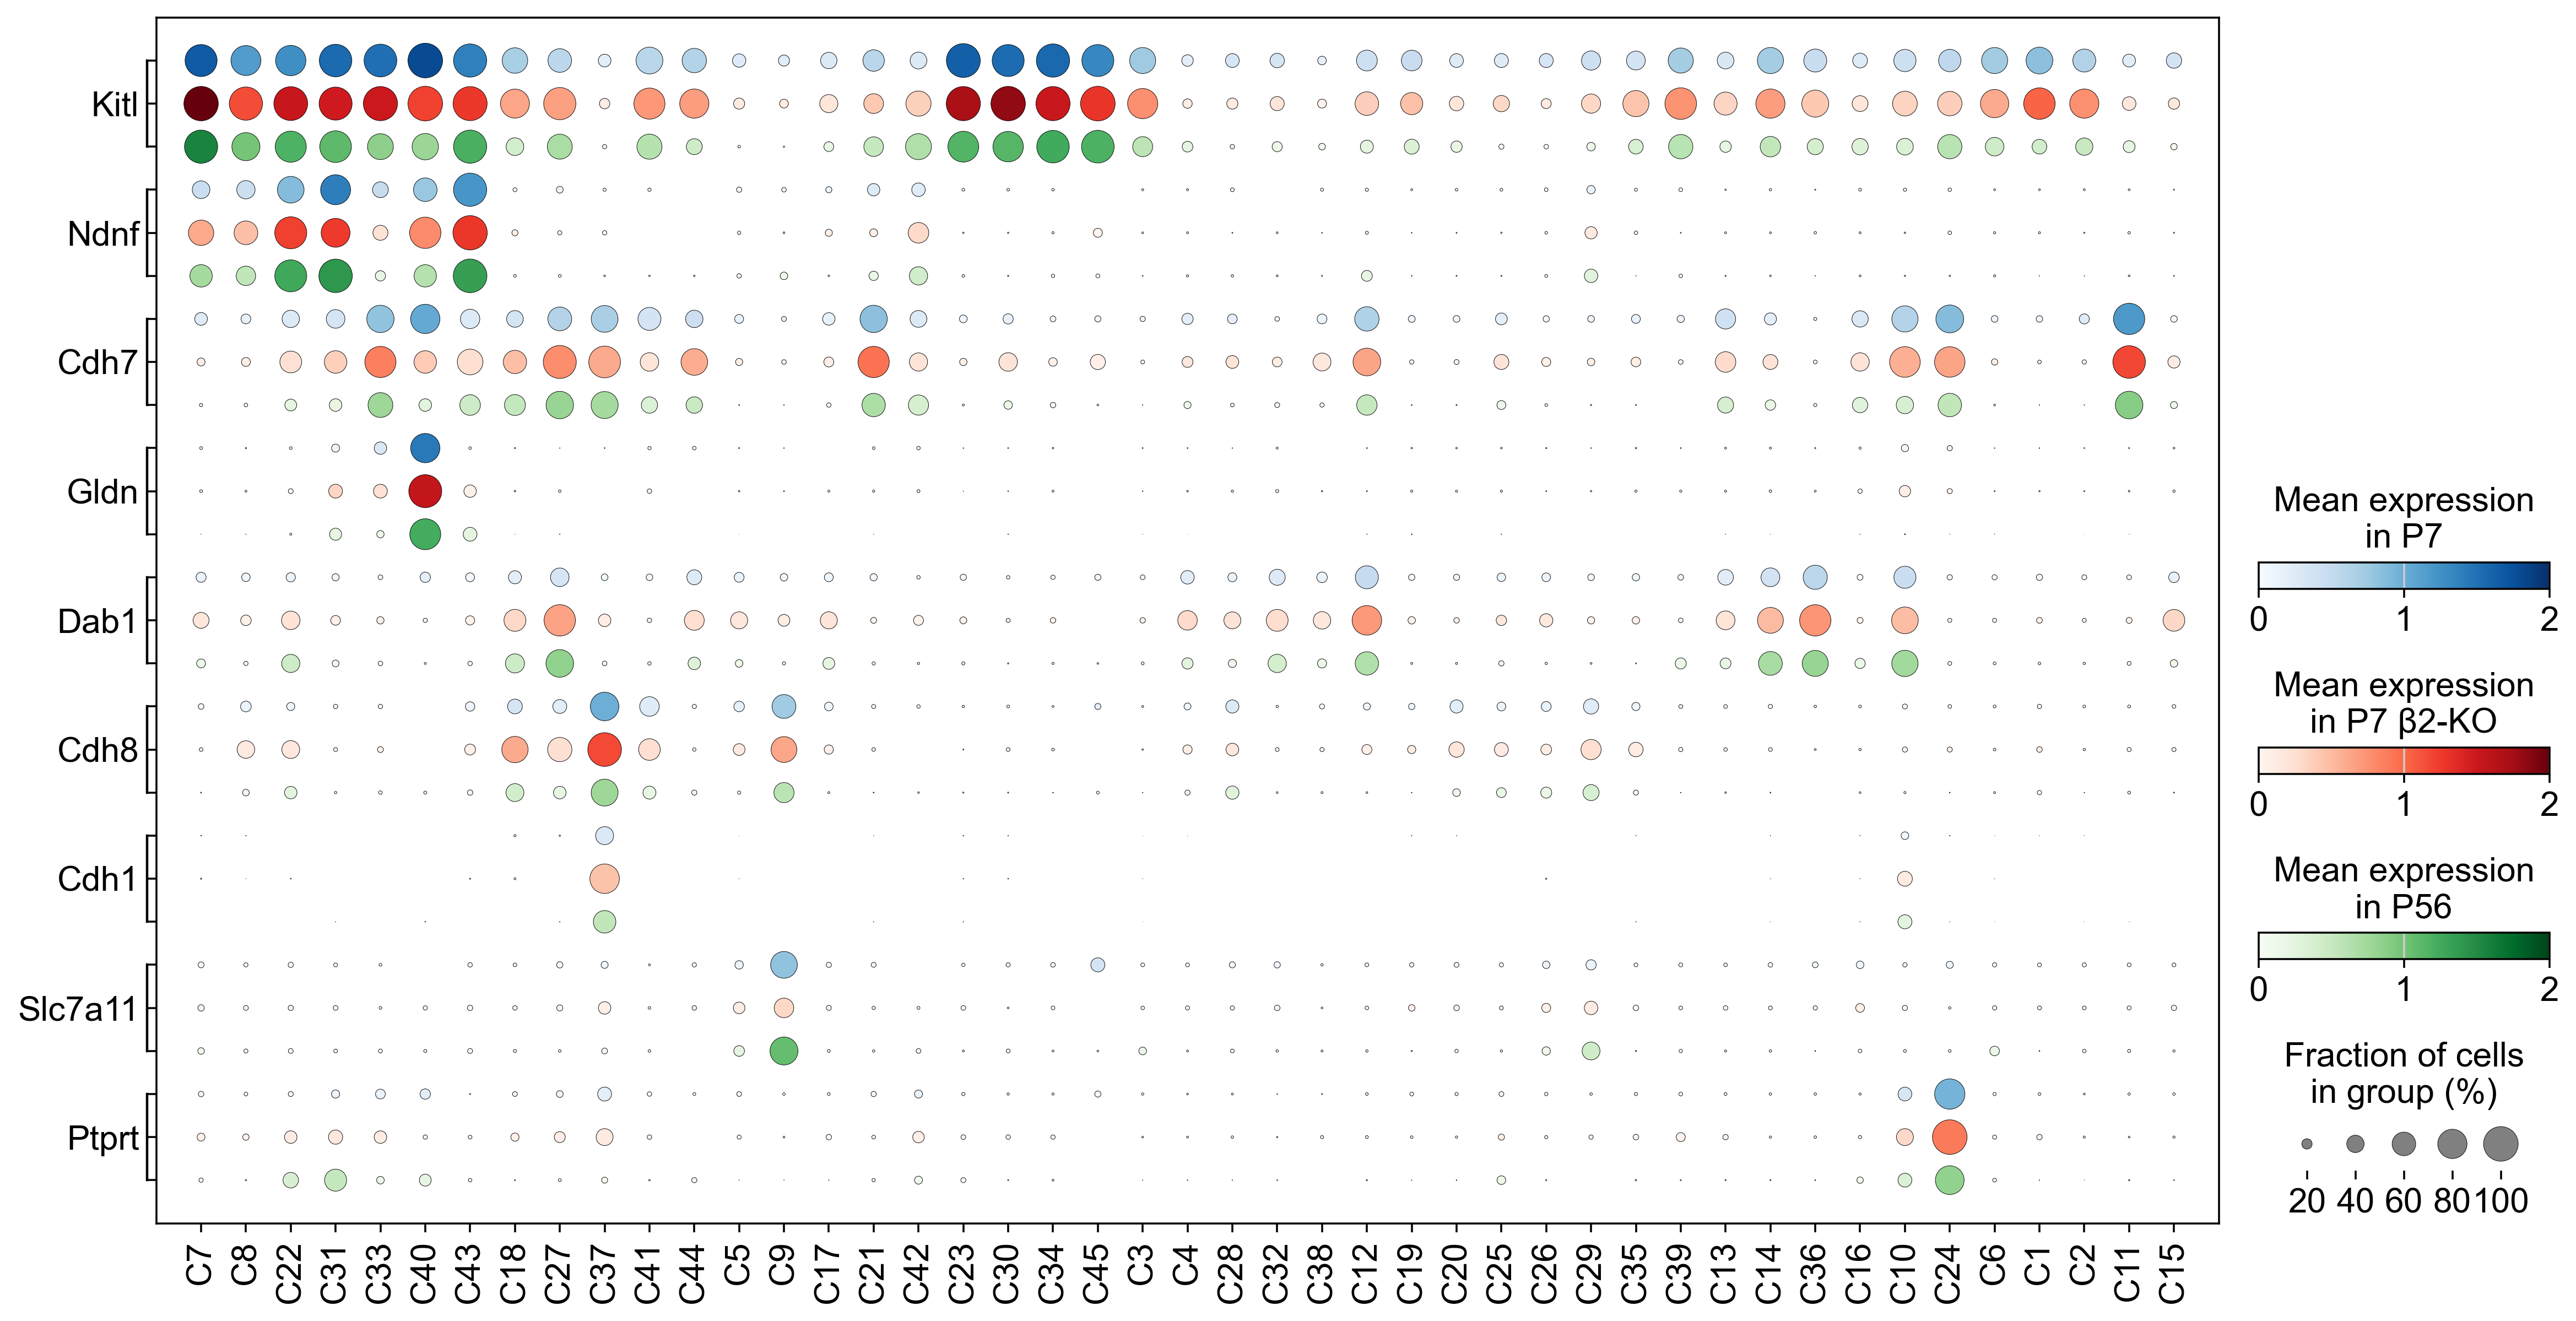

In [103]:
plot_multidotplot([adata_p7, adata_p7b2, adata_p56], ['Blues', 'Reds', 'Greens'], 'C_type', type_list, supplemental_CAs, adata_names=['P7','P7 β2-KO','P56'], save='supp_CAs.svg')